In [1]:
import numpy as np
import pandas as pd
np.random.seed(7)

# my own libraries
import prepare_data
import inspect_results as inspect

# for baselines
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# for the deep learning model
import tensorflow.keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, LSTM, Bidirectional, GRU
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers, losses, activations
from tensorflow.keras.callbacks import EarlyStopping

# for visualization
import matplotlib.pyplot as plt

# Load Data

Succesfully loaded PHM08 data from ../../Datasets/PHM08_Challenge_Data/train.txt
Succesfully calculated the CTFs (Cycles to Failure).
Succesfully calculated the RULs (Remaining Useful Lives).
Succesfully calculated the Heath States.


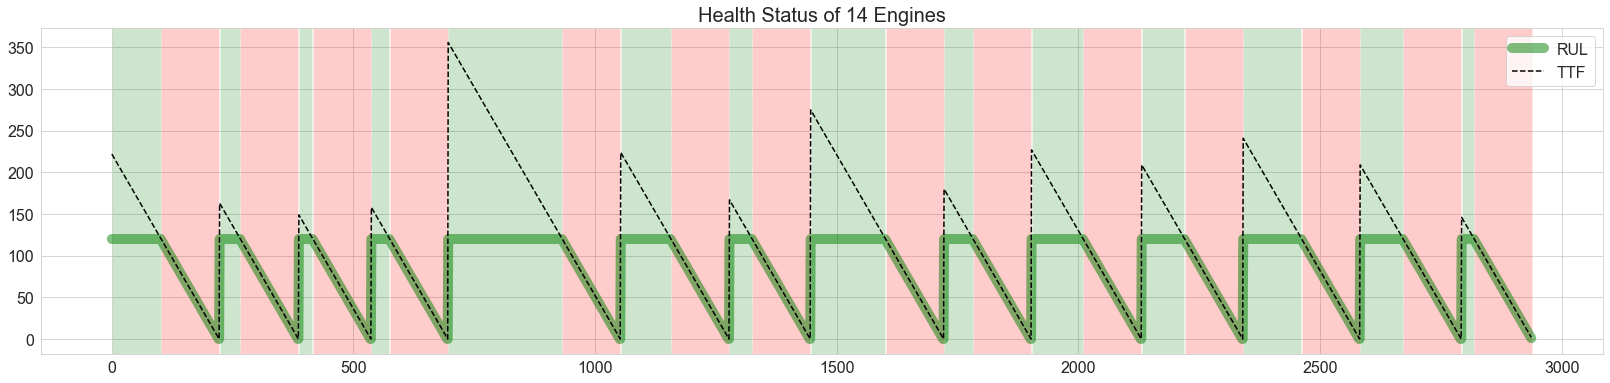

In [2]:
cmapss = prepare_data.CMAPSS()

"""dev model should be fisrt true, 
and only if we decide to start labeling 
the test set provided by NASA we should set it to FALSE"""
dev_mode = True 

path = "../../Datasets/PHM08_Challenge_Data/train.txt"

dev_data = cmapss.load_data(path)
dev_data = cmapss.cluster_operational_settings(dev_data, dev_mode)
dev_data = cmapss.calculate_TTF(dev_data)
dev_data = cmapss.calculate_continues_healthstate(dev_data)
dev_data = cmapss.calculate_descrete_healthstate(dev_data)
cmapss.visualize_healthstatus(dev_data, 14) # engines to visualize

# Preprocess Data
## prepare train set

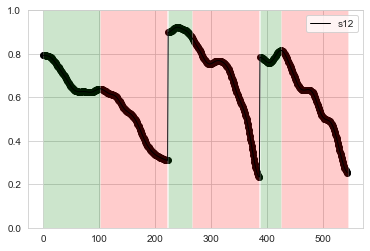

In [3]:
dev_data = cmapss.get_univariate_cmapss(dev_data, "s12")
x_train, x_test = cmapss.train_test_split(dev_data)
x_train = cmapss.minmax_scale(x_train)
x_train = cmapss.denoise_sensors(x_train)
cmapss.visualize_denoised_sensors(x_train, 3)

## prepare test set

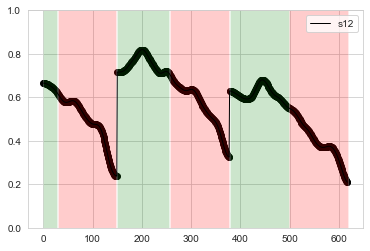

In [4]:
x_test = cmapss.minmax_scale(x_test)
x_test = cmapss.denoise_sensors(x_test)
cmapss.visualize_denoised_sensors(x_test, 3)

## Prepare Input Shape

In [5]:
w_size=20
x_train, y_train = cmapss.window_data(x_train, w_size, w_size//2)
x_test, y_test = cmapss.window_data(x_test, w_size, w_size//2)

print("Trainset shape: data={}\nTestset shape: data={}".format(
      x_train.shape, x_test.shape))

Trainset shape: data=(3136, 20)
Testset shape: data=(1332, 20)


# Baselines

## Linear Models 
### Logistic Regression

C:\Users\jalalia\AppData\Local\Continuum\anaconda2\envs\tensorflow-py3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



X_TEST Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.76      0.75       531
           1       0.84      0.83      0.83       801

    accuracy                           0.80      1332
   macro avg       0.79      0.79      0.79      1332
weighted avg       0.80      0.80      0.80      1332



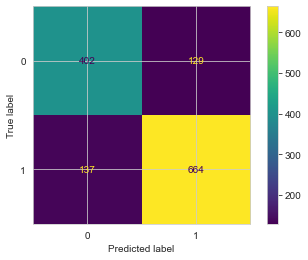

In [6]:
lr = LogisticRegressionCV(cv=10, random_state=7).fit(x_train, y_train)
lr_pred_test = lr.predict(x_test)

print('\nX_TEST Classification Report:\n')
inspect.plot_classification_report(y_test, lr_pred_test)

### Ridge Classifier


X_TEST Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.76      0.74       531
           1       0.83      0.81      0.82       801

    accuracy                           0.79      1332
   macro avg       0.78      0.79      0.78      1332
weighted avg       0.79      0.79      0.79      1332



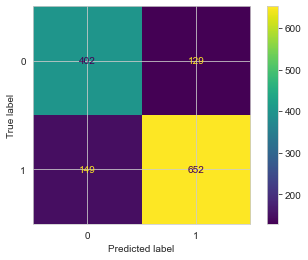

In [7]:
ridge = RidgeClassifierCV(cv=10).fit(x_train, y_train)
ridge_pred_test = ridge.predict(x_test)

print('\nX_TEST Classification Report:\n')
inspect.plot_classification_report(y_test, ridge_pred_test)

## Distance-based model
### K-Nearest Neighbour


X_TEST Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.76      0.74       531
           1       0.83      0.81      0.82       801

    accuracy                           0.79      1332
   macro avg       0.78      0.79      0.78      1332
weighted avg       0.79      0.79      0.79      1332



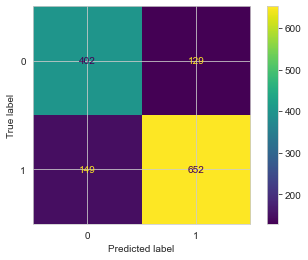

In [8]:
knn = KNeighborsClassifier(n_neighbors=3).fit(x_train, y_train)
knn_pred_test = knn.predict(x_test)

print('\nX_TEST Classification Report:\n')
inspect.plot_classification_report(y_test, ridge_pred_test)

## Rule-Based Model
### Decision Tree


X_TEST Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       531
           1       0.81      0.82      0.82       801

    accuracy                           0.78      1332
   macro avg       0.77      0.77      0.77      1332
weighted avg       0.78      0.78      0.78      1332



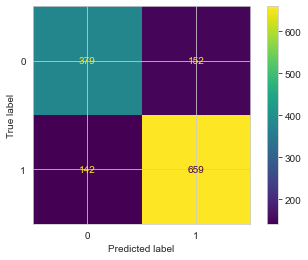

In [9]:
dt = DecisionTreeClassifier(random_state=7,
                            max_depth=5).fit(x_train, y_train)
dt_pred_test = dt.predict(x_test)

print('\nX_TEST Classification Report:\n')
inspect.plot_classification_report(y_test, dt_pred_test)

### Visualize the Tree (See where the decision cuts are)

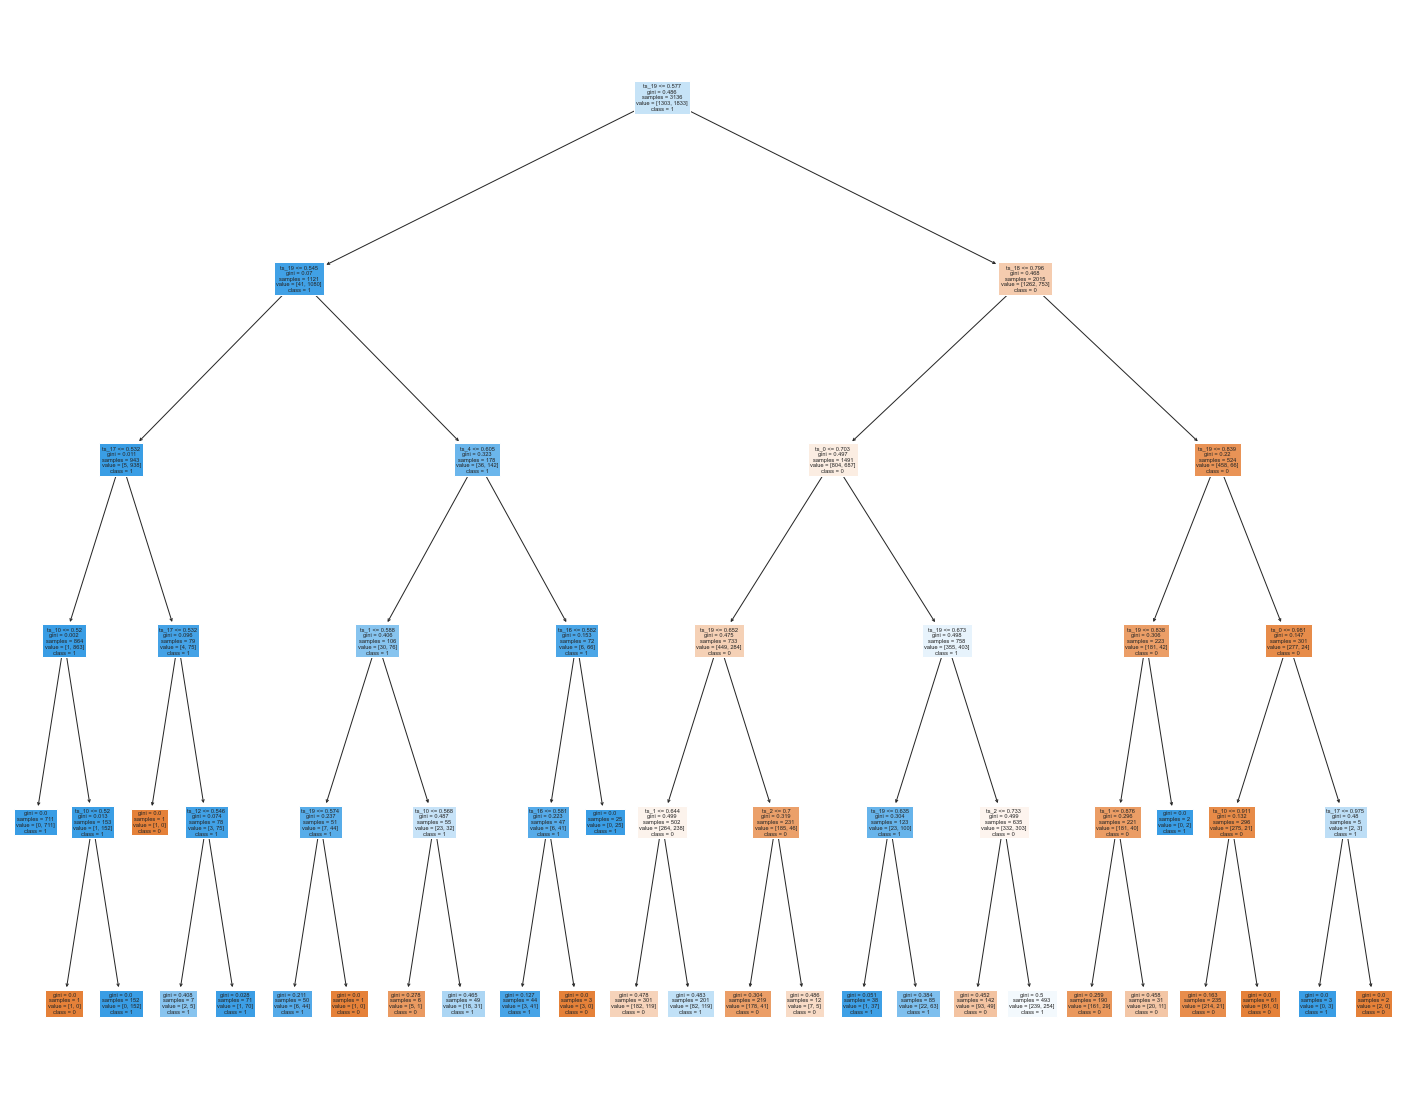

In [10]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt, 
                   feature_names=["ts_{}".format(i) # each timestep is a feature
                                  for i in range(x_train.shape[1])],  
                   class_names=["0", "1"], # 0=healthy, 1=unhealthy
                   filled=True)

# Build Deep Learning Model

We choose a sequential model for our binary time series classifier. For this purpose, we build a Long-Short Term Memory (an extention of RNN models).

In [11]:
input_shape = (x_train.shape[1], 1)

x_train = np.asarray(x_train, dtype="float")
y_train = np.asarray(y_train, dtype="float")

x_test = np.asarray(x_test, dtype="float")
y_test = np.asarray(y_test, dtype="float")

## Vanilla LSTM
### Build

source: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [12]:
vanilla_lstm = Sequential()
vanilla_lstm.add(LSTM(20, input_shape=input_shape))
vanilla_lstm.add(Dense(1, activation="sigmoid")) 

vanilla_lstm.compile(loss="binary_crossentropy", optimizer="sgd")
vanilla_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


### Train

In [13]:
vanilla_lstm_history = vanilla_lstm.fit(x_train[:, :, np.newaxis], y_train,
                                        validation_split=0.30,
                                        epochs=20, verbose=1)

Epoch 1/20
69/69 [==============================] - 6s 32ms/step - loss: 0.6918 - val_loss: 0.6844
Epoch 2/20
69/69 [==============================] - 1s 9ms/step - loss: 0.6863 - val_loss: 0.6787
Epoch 3/20
69/69 [==============================] - 1s 10ms/step - loss: 0.6812 - val_loss: 0.6745
Epoch 4/20
69/69 [==============================] - 1s 9ms/step - loss: 0.6768 - val_loss: 0.6710
Epoch 5/20
69/69 [==============================] - 1s 9ms/step - loss: 0.6718 - val_loss: 0.6675
Epoch 6/20
69/69 [==============================] - 1s 9ms/step - loss: 0.6704 - val_loss: 0.6637
Epoch 7/20
69/69 [==============================] - 1s 9ms/step - loss: 0.6678 - val_loss: 0.6597
Epoch 8/20
69/69 [==============================] - 1s 10ms/step - loss: 0.6613 - val_loss: 0.6551
Epoch 9/20
69/69 [==============================] - 1s 10ms/step - loss: 0.6556 - val_loss: 0.6499
Epoch 10/20
69/69 [==============================] - 1s 10ms/step - loss: 0.6493 - val_loss: 0.6438
Epoch 11/20
69

### Evaluation

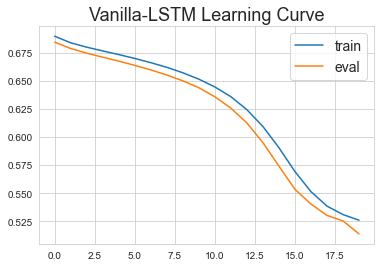

In [14]:
# plot learning curves
plt.title("Vanilla-LSTM Learning Curve", fontsize=18)
plt.plot(vanilla_lstm_history.history['loss'], label='train')
plt.plot(vanilla_lstm_history.history['val_loss'], label='eval')
plt.legend(fontsize=14)


X_TEST Classification Report:

              precision    recall  f1-score   support

         0.0       0.65      0.75      0.70       531
         1.0       0.82      0.73      0.77       801

    accuracy                           0.74      1332
   macro avg       0.73      0.74      0.73      1332
weighted avg       0.75      0.74      0.74      1332



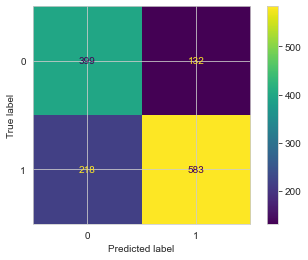

In [15]:
vlstm_pred_test = vanilla_lstm.predict(x_test[:, :, np.newaxis])

print('\nX_TEST Classification Report:\n')
inspect.plot_classification_report(y_test,
                                   inspect.continues_to_binary(vlstm_pred_test))

## Fine-Tuned LSTM
### Build

In [16]:
lr = 0.01
optimizer = 'adam'
neurons = 64
dropout = 0.25
activation = 'tanh'
loss_function = 'binary_crossentropy'

batchSize = 32
epochs = 500
verbose = 1

opt = None
if optimizer == 'sgd':
    opt = optimizers.SGD(lr=lr, decay=1e-6,
                         momentum=0.9, nesterov=True)
elif optimizer == 'rmsprop':
    opt = optimizers.RMSprop(lr=lr, rho=0.9,
                             epsilon=1e-08, decay=0.01)
elif optimizer == 'adam':
    opt = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999,
                          epsilon=1e-08, decay=0.01)
    
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')


"""Build the model"""
lstm = Sequential()

lstm.add(LSTM(neurons, activation=activation, 
               return_sequences=True,
               input_shape=input_shape))
lstm.add(Dropout(dropout))

# lstm.add(LSTM(neurons, activation=activation, return_sequences=True,))  
# lstm.add(Dropout(dropout))

lstm.add(LSTM(neurons, activation=activation))  
lstm.add(Dropout(dropout))

lstm.add(Dense(1, activation="sigmoid"))          
lstm.compile(loss=loss_function, optimizer=opt)
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 64)            16896     
_________________________________________________________________
dropout (Dropout)            (None, 20, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


### Train 

In [17]:
lstm_history = lstm.fit(x_train[:, :, np.newaxis], y_train,
                        validation_split=0.25,
                        callbacks = [earlystop],
                        batch_size=batchSize,
                        epochs=epochs,
                        verbose=verbose)

Epoch 1/500
74/74 [==============================] - 10s 47ms/step - loss: 0.6042 - val_loss: 0.4704
Epoch 2/500
74/74 [==============================] - 2s 22ms/step - loss: 0.4825 - val_loss: 0.4618
Epoch 3/500
74/74 [==============================] - 2s 22ms/step - loss: 0.4704 - val_loss: 0.4833
Epoch 4/500
74/74 [==============================] - 2s 22ms/step - loss: 0.4662 - val_loss: 0.4556
Epoch 5/500
74/74 [==============================] - 2s 23ms/step - loss: 0.4565 - val_loss: 0.4433
Epoch 6/500
74/74 [==============================] - 2s 22ms/step - loss: 0.4458 - val_loss: 0.4270
Epoch 7/500
74/74 [==============================] - 2s 22ms/step - loss: 0.4420 - val_loss: 0.4481
Epoch 8/500
74/74 [==============================] - 2s 22ms/step - loss: 0.4308 - val_loss: 0.4206
Epoch 9/500
74/74 [==============================] - 2s 22ms/step - loss: 0.4404 - val_loss: 0.4213
Epoch 10/500
74/74 [==============================] - 2s 22ms/step - loss: 0.4417 - val_loss: 0.419

### Evaluation

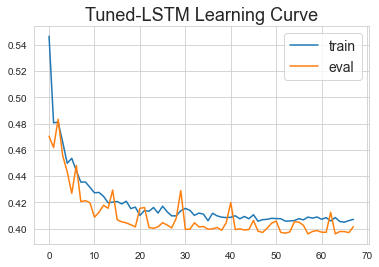

In [18]:
# plot learning curves
plt.title("Tuned-LSTM Learning Curve", fontsize=18)
plt.plot(lstm_history.history['loss'], label='train')
plt.plot(lstm_history.history['val_loss'], label='eval')
plt.legend(fontsize=14)


X_TEST Classification Report:

              precision    recall  f1-score   support

         0.0       0.71      0.82      0.76       531
         1.0       0.87      0.78      0.82       801

    accuracy                           0.79      1332
   macro avg       0.79      0.80      0.79      1332
weighted avg       0.80      0.79      0.80      1332



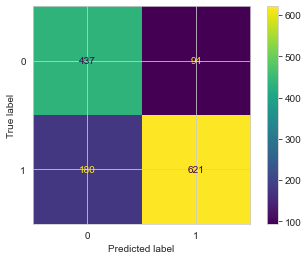

In [19]:
lstm_pred_test = lstm.predict(x_test[:, :, np.newaxis])

print('\nX_TEST Classification Report:\n')
inspect.plot_classification_report(y_test,
                                   inspect.continues_to_binary(lstm_pred_test))

# Model Inspection

## Where does model fail on the unseen data?

Here, I would like to see if there is a pattern in the failed predictions. 
For this, I cluster the test data within each of its class. Then I look to see which clusters have failed predictions and weather the samples with failed predictions are close to the predicted class, and further from their true class.

### Clustered test set (by their true labels)

In [20]:
labels_are_predicted = False
test_cluster = inspect.get_clustered_data(x_test, y_test, labels_are_predicted)

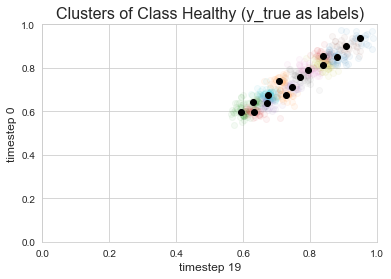

In [21]:
inspect.visualize_clusters(test_cluster["healthy_data"],
                           test_cluster["healthy_clusters"],
                           "Clusters of Class Healthy (y_true as labels)")

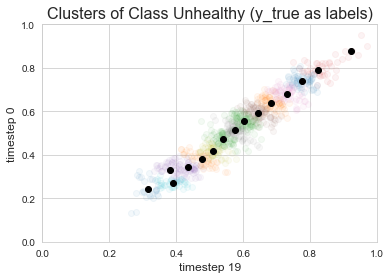

In [22]:
inspect.visualize_clusters(test_cluster["unhealthy_data"],
                           test_cluster["unhealthy_clusters"],
                           "Clusters of Class Unhealthy (y_true as labels)")

### Clustered test set (by their predicted labels)

In [23]:
labels_are_predicted = True
test_cluster = inspect.get_clustered_data(x_test,
                                          inspect.continues_to_binary(lstm_pred_test),
                                          labels_are_predicted)

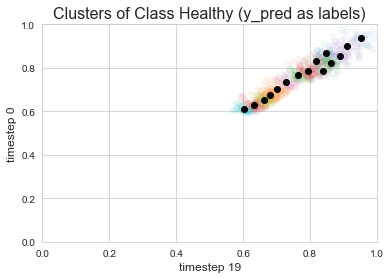

In [24]:
inspect.visualize_clusters(test_cluster["healthy_data"],
                           test_cluster["healthy_clusters"],
                           "Clusters of Class Healthy (y_pred as labels)")

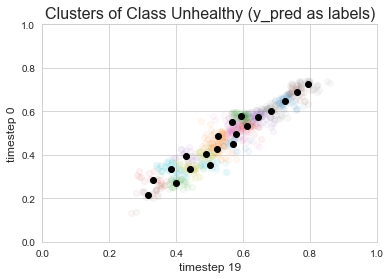

In [25]:
inspect.visualize_clusters(test_cluster["unhealthy_data"],
                           test_cluster["unhealthy_clusters"],
                           "Clusters of Class Unhealthy (y_pred as labels)")

In [26]:
test_cluster_df = inspect.get_clustered_df(x_test, y_test, lstm_pred_test)

### Plot all the data

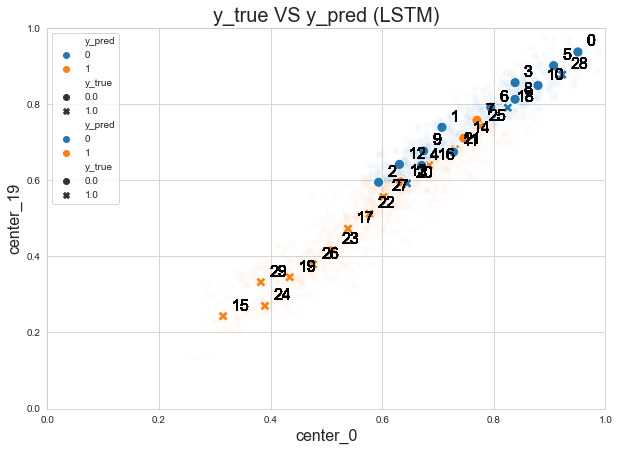

In [27]:
inspect.visualize_predictions(test_cluster_df, "LSTM")

### Plot Failed predictions

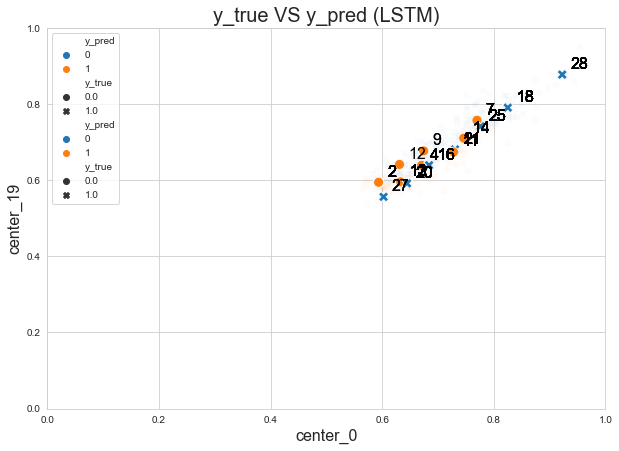

In [28]:
inspect.visualize_predictions(test_cluster_df[
    test_cluster_df.y_true != test_cluster_df.y_pred],
                      "LSTM")

### Plot False Positives

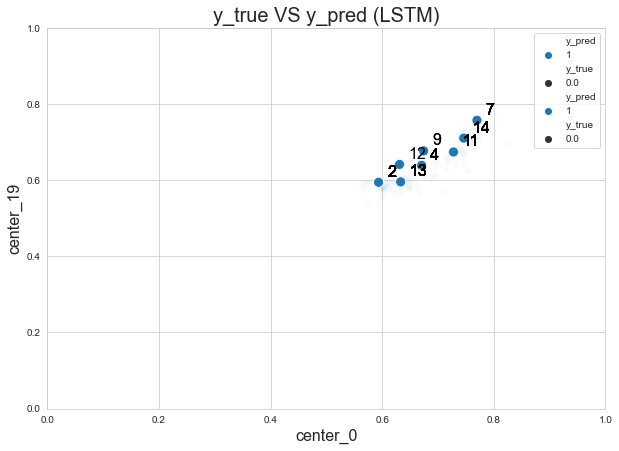

In [29]:
inspect.visualize_predictions(test_cluster_df[
    (test_cluster_df.y_true==0) & (test_cluster_df.y_pred==1)],
                      "LSTM")

### Plot False Negatives

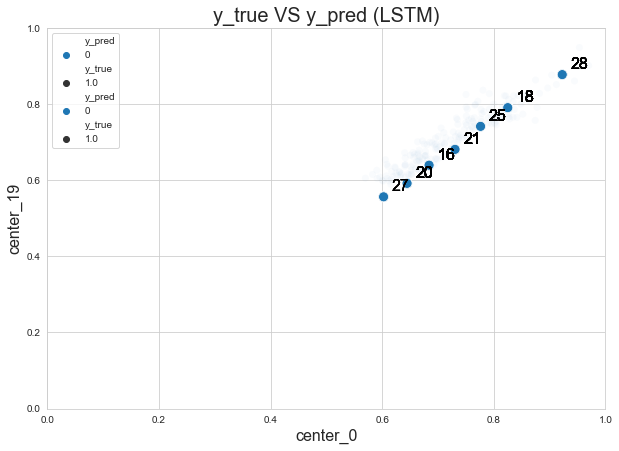

In [30]:
inspect.visualize_predictions(test_cluster_df[
    (test_cluster_df.y_true==1) & (test_cluster_df.y_pred==0)],
                      "LSTM")

## Where does model fail on the train data?
Here, I would like to see if there is a pattern in the failed predictions of what the model was learning. The same as the test set, I cluster the train data within each of its class. Then I look to see which clusters have failed predictions and whether the samples with failed predictions are close to the predicted class, and further from their true class.

### Clustered train set (by their true labels)

In [31]:
labels_are_predicted = False
train_cluster = inspect.get_clustered_data(x_train, y_train, labels_are_predicted)

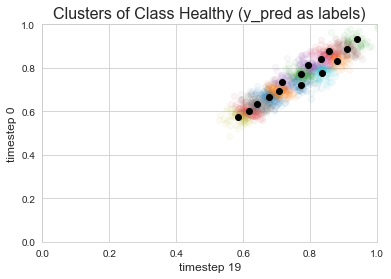

In [32]:
inspect.visualize_clusters(train_cluster["healthy_data"],
                           train_cluster["healthy_clusters"],
                           "Clusters of Class Healthy (y_pred as labels)")

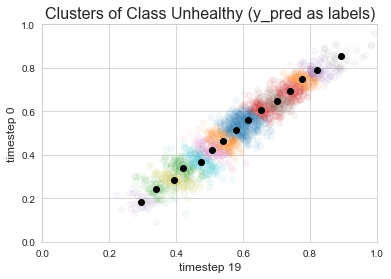

In [33]:
inspect.visualize_clusters(train_cluster["unhealthy_data"],
                           train_cluster["unhealthy_clusters"],
                           "Clusters of Class Unhealthy (y_pred as labels)")

### Clustered train set (by their predicted labels)


X_TRAIN Classification Report:

              precision    recall  f1-score   support

         0.0       0.72      0.82      0.76      1303
         1.0       0.86      0.77      0.81      1833

    accuracy                           0.79      3136
   macro avg       0.79      0.79      0.79      3136
weighted avg       0.80      0.79      0.79      3136



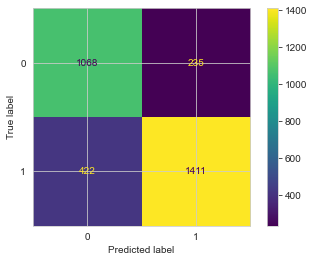

In [34]:
lstm_pred_train = lstm.predict(x_train[:, :, np.newaxis])

print('\nX_TRAIN Classification Report:\n')
inspect.plot_classification_report(y_train,
                                   inspect.continues_to_binary(lstm_pred_train))

In [35]:
labels_are_predicted = True
train_cluster = inspect.get_clustered_data(x_train,
                                           inspect.continues_to_binary(lstm_pred_train),
                                           labels_are_predicted)

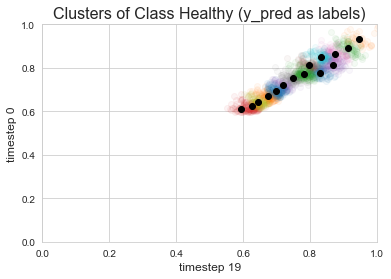

In [36]:
inspect.visualize_clusters(train_cluster["healthy_data"],
                           train_cluster["healthy_clusters"],
                           "Clusters of Class Healthy (y_pred as labels)")

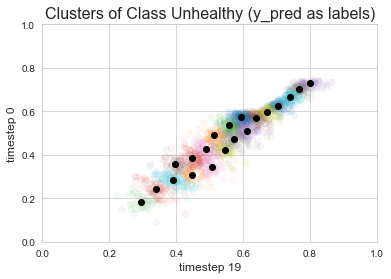

In [37]:
inspect.visualize_clusters(train_cluster["unhealthy_data"],
                           train_cluster["unhealthy_clusters"],
                           "Clusters of Class Unhealthy (y_pred as labels)")

In [38]:
train_cluster_df = inspect.get_clustered_df(x_train, y_train, lstm_pred_train)

### Plot all the data

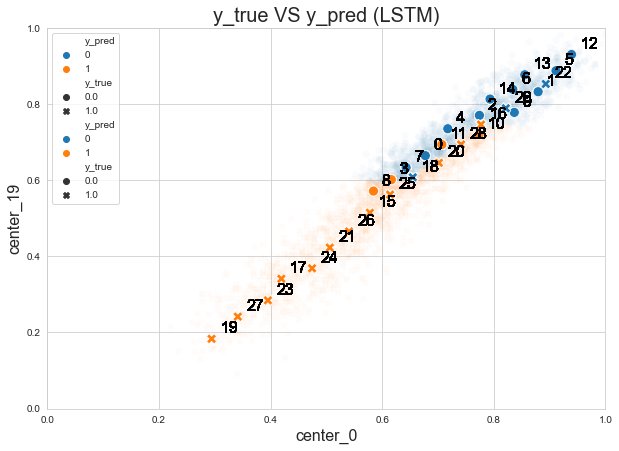

In [39]:
inspect.visualize_predictions(train_cluster_df, "LSTM")

### Plot Failed Predictions

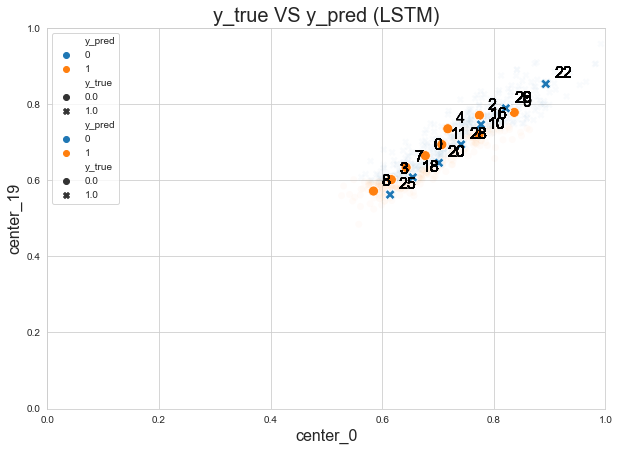

In [40]:
inspect.visualize_predictions(train_cluster_df[
    train_cluster_df.y_true != train_cluster_df.y_pred],
                      "LSTM")

### Plot False Positives

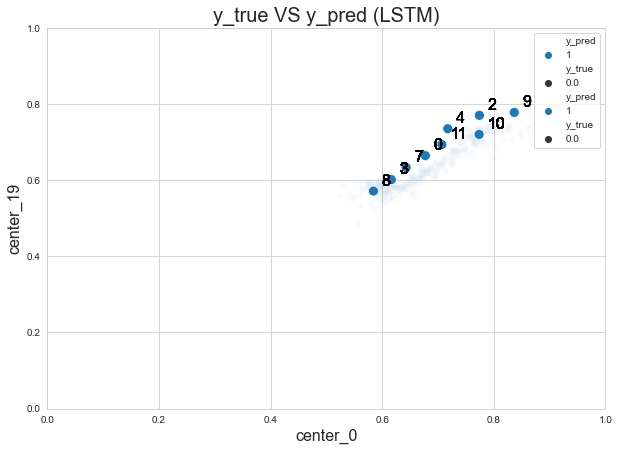

In [41]:
inspect.visualize_predictions(train_cluster_df[
    (train_cluster_df.y_true==0) & (train_cluster_df.y_pred==1)],
                      "LSTM")

### Plot False Negatives

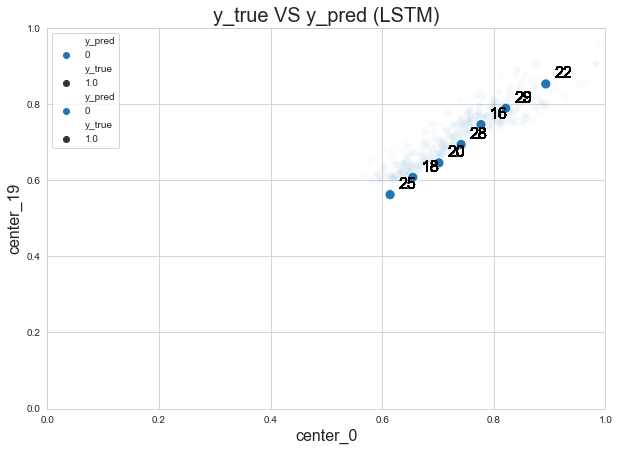

In [42]:
inspect.visualize_predictions(train_cluster_df[
    (train_cluster_df.y_true==1) & (train_cluster_df.y_pred==0)],
                      "LSTM")

# Explainability

In this section, I would like to:

1. Understand the prediction of the model, by looking at the factual and counterfactual examples. My idea is to pick these examples by looking at the closest correctly predicted samples.
2. Train a surrogate model to understand the highly influential time series characteristics, on the model decision. 
3. Using the decision cuts of the surrigate model, I would like to understand the influence of the parameters.

## Extracting Factual and Counterfactual Examples

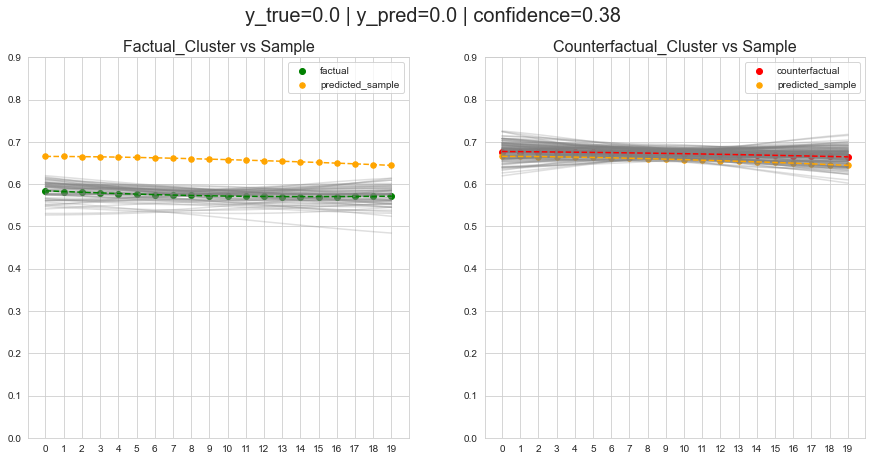

In [43]:
import explainability as explainer

# select a sample from the test set to get the explanations
# or the train set, depending what data we pass on to the function
test_df = explainer.get_predictions_as_df(x_test, y_test, lstm_pred_test)

selected_sample = test_df.iloc[0]
explainer.get_counter_and_factuals(train_cluster, train_cluster_df, selected_sample)

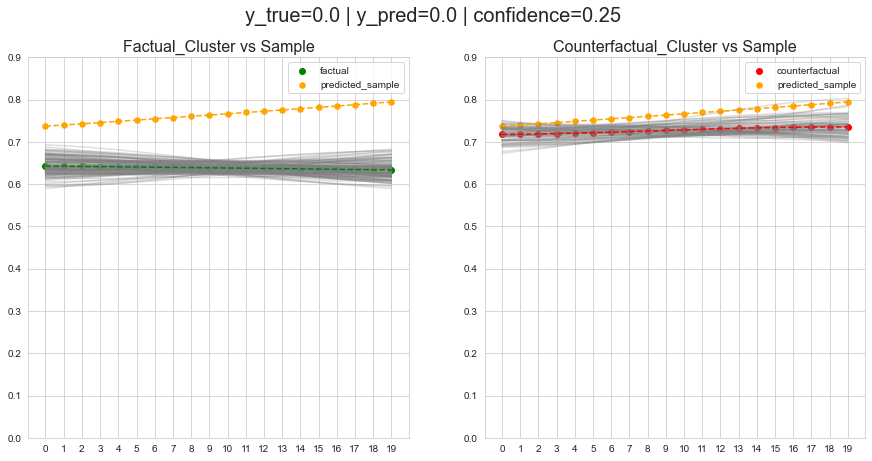

In [44]:
selected_sample = test_df.iloc[16]
explainer.get_counter_and_factuals(train_cluster, train_cluster_df, selected_sample)

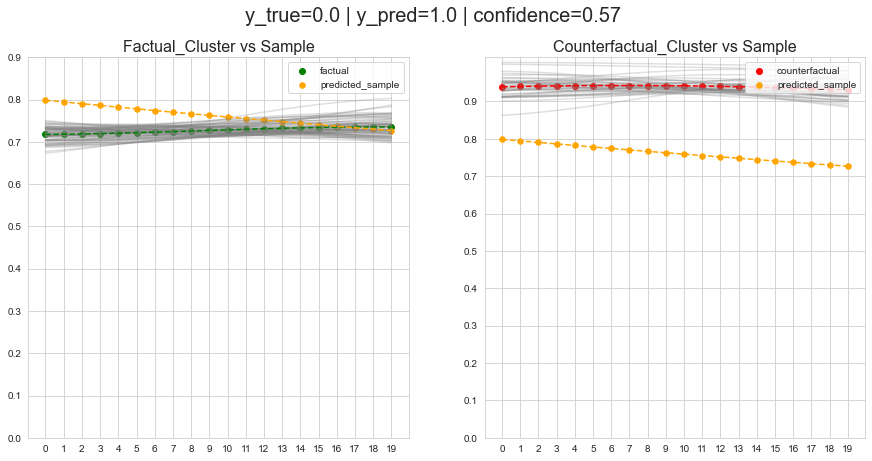

In [45]:
selected_sample = test_df.iloc[20]
explainer.get_counter_and_factuals(train_cluster, train_cluster_df, selected_sample)

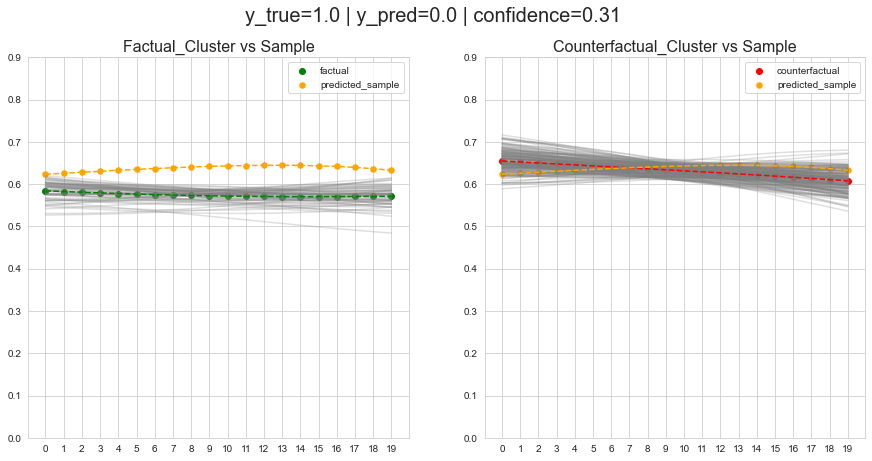

In [46]:
selected_sample = test_df.iloc[1245]
explainer.get_counter_and_factuals(train_cluster, train_cluster_df, selected_sample)

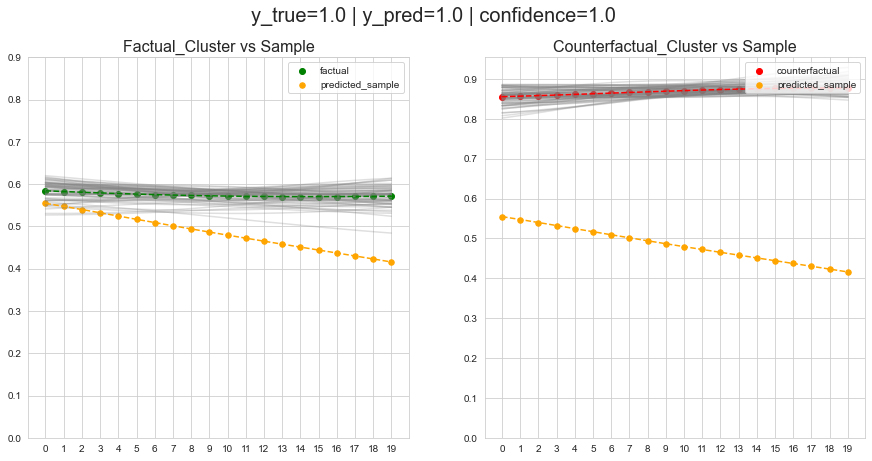

In [47]:
selected_sample = test_df.iloc[168]
explainer.get_counter_and_factuals(train_cluster, train_cluster_df, selected_sample)

## Global Surrogate Explanations 
**of Human Interpretable Time Series Characteristics**



In this sction, we extract some human interpretable time series characteristics such as frequency domain features (e.g., frequency) and time domain features (e.g., mean of amplitute, standard deviation, pitch and min values of the time series).
Afterwards, we train a global surrogate model on the extracted features. 

Our assumption here is that, the complex LSTM has already extracted these features from the raw data and since we use the LSTM predictions to train our surrogate decision tree, we can compare these two models and the tree could help us to understand the decisions made by LSTMs, as well as the responsible time series features.

### Extract features

In [48]:
dev_features = explainer.extract_time_series_features(dev_data, "s12", w_size)

ts_features_train, ts_features_test, feature_names = dev_features
print(ts_features_train.shape, ts_features_test.shape)

(3136, 100) (1332, 100)


### Train Surrogate Tree


X_Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       617
           1       0.97      0.97      0.97       715

    accuracy                           0.97      1332
   macro avg       0.97      0.97      0.97      1332
weighted avg       0.97      0.97      0.97      1332



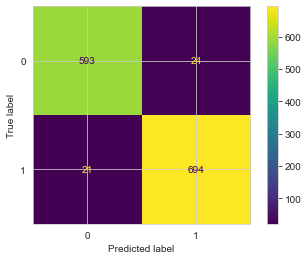

In [49]:
from sklearn.tree import DecisionTreeClassifier


surrogate_dt = DecisionTreeClassifier(random_state=7)
surrogate_dt.fit(ts_features_train,
                 inspect.continues_to_binary(lstm_pred_train))

surrogate_dt_train_preds = surrogate_dt.predict(ts_features_train)

surrogate_dt_test_preds = surrogate_dt.predict(ts_features_test)
print('\nX_Classification Report:\n')
inspect.plot_classification_report(inspect.continues_to_binary(lstm_pred_test),
                                   surrogate_dt_test_preds)

### Get the most influential features

,importance
mean_19,75.564856
fft_14,13.048159
mean_0,3.095419
min_16,0.886406
fft_16,0.659428
min_5,0.543213
min_9,0.486830
std_12,0.361564
std_18,0.353809
fft_9,0.335966


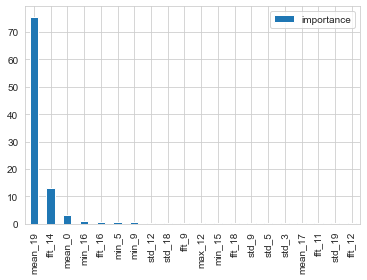

In [50]:
importance = surrogate_dt.feature_importances_
# summarize feature importance
f_imp = pd.DataFrame(importance, columns=["importance"])
f_imp.index = feature_names
f_imp["importance"] = f_imp.importance.values * 100

f_imp=f_imp.sort_values(by=['importance'], ascending=False)
display(f_imp.head(10))
# plot feature importance

f_imp[:20].plot(kind="bar")
plt.show()

### Visualize the decision cuts

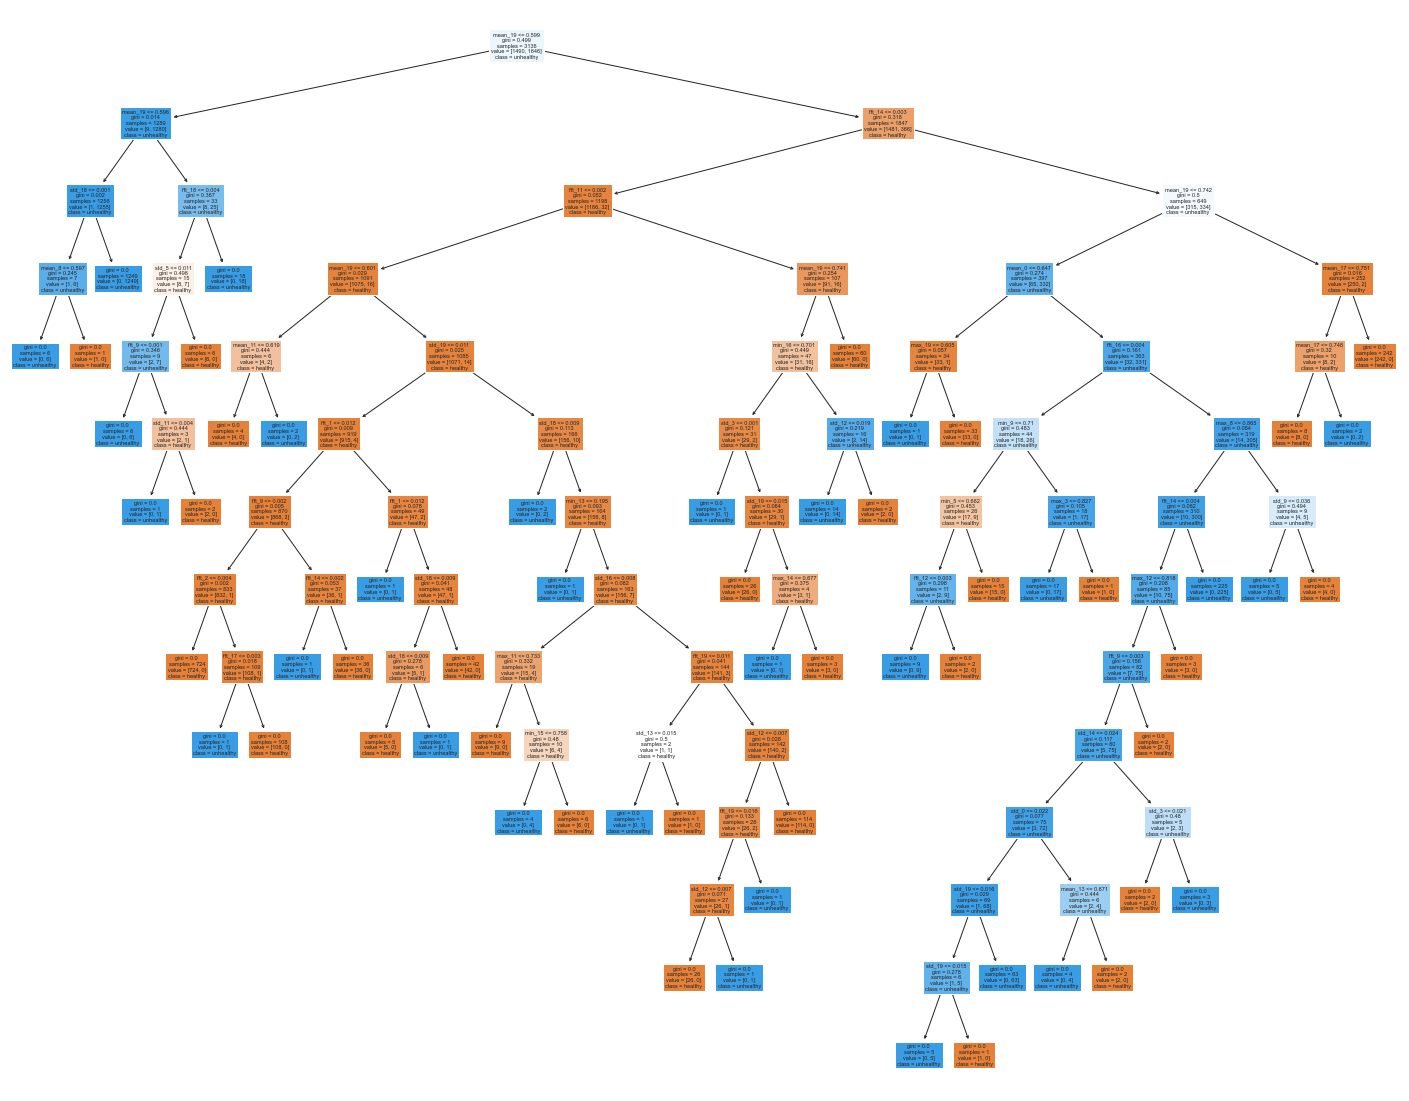

In [51]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(surrogate_dt, 
                   feature_names=feature_names,  
                   class_names=["healthy", "unhealthy"],
                   filled=True)

**My Next Steps:**

I would like to continue further with the idea and work on

1. the generated local neighborhood is too small. Therefore, I cannot train a stable surrogate model --> I look into the existing time series synthetic data generation to synthetically generate more data in a neighborhood.

2. I would like to work further on the inspection module and look at the failed clusters and the factual and counterfactual clusters vs. a given sample. 

3. the results of step 2 can help me find whether my labeled data is correctly labeled. And if a cluster should be labeled differently, I can provide the visualization to an expert. The expert can accept or reject the recommended label. This moves my approach from a model-centric approach to a data-centric machine learning, in which I can also improve the quality of the data using the explanations. 